## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


## Helper Functions

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
        
   
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Line Detection Pipeline 

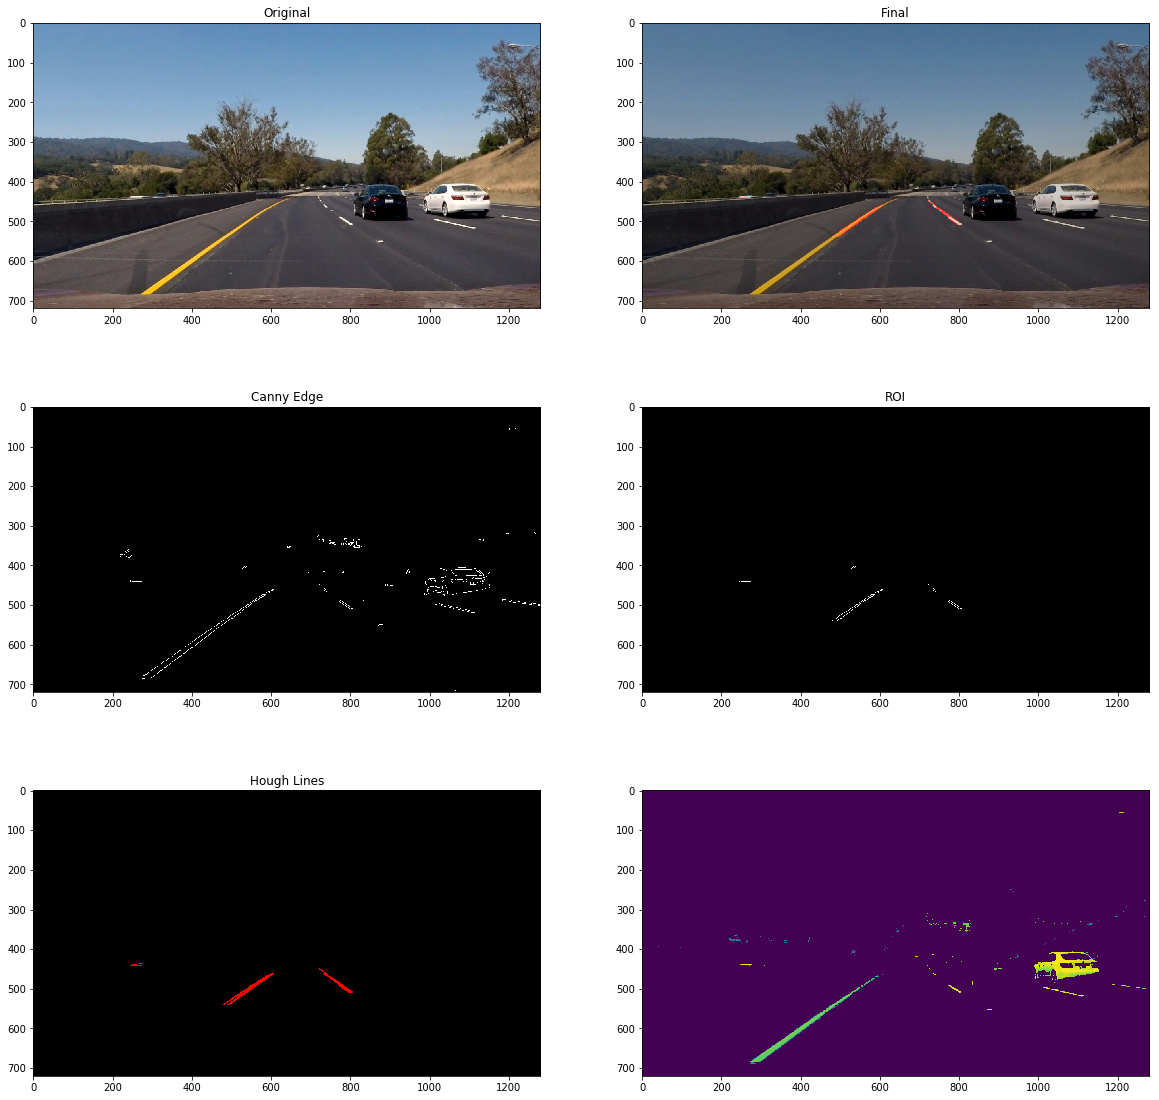

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [102]:
import os

# Read in the Image
image1 = mpimg.imread('test_images/solidWhiteRight.jpg')
image2 = mpimg.imread('test_images/solidWhiteCurve.jpg')
image3 = mpimg.imread('test_images/solidYellowCurve.jpg')
image4 = mpimg.imread('test_images/solidYellowLeft.jpg')
image5 = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
image6 = mpimg.imread('test_images/exit-ramp.jpg')
image7 = mpimg.imread('test_images/sfv1.jpeg')

def my_processing(image):
    # Convert image to grayscale
    gray = grayscale(image)
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    

    
    ##  Mask for only white and yellow lines
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
    mask_white = cv2.inRange(gray, 200, 255)
    mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
    mask_yw_image = cv2.bitwise_and(gray, mask_yw)
                            
                            
    
    # Apply Gaussian filter to smooth image and remove noise
    gauss = cv2.GaussianBlur(mask_yw_image,(7,7), 0)

    # Do Canny Edge Detection   (skipping the white/yellow mask leads to extra lines)
    low_threshold = 100
    high_threshold = 200
    canny_edges = canny(gauss,low_threshold,high_threshold)

    # Region of Interest
    #vertices = [np.array([[80,540],[465,220],[500,220],[900,540]], dtype=np.int32)]
    vertices = [np.array([[80,540],[465,310],[500,310],[900,540]], dtype=np.int32)]

    ROI_masked = region_of_interest(canny_edges, vertices)

    polygon = cv2.polylines(image6,vertices,True,(0,255,255))


    # Hough Transform
    #rho and theta are the distance and angular resolution of the grid in Hough space
    #threshold is minimum number of intersections in a grid for candidate line to go to output
    rho = 1
    theta = np.pi/180
    threshold = 10
    min_line_len = 10
    max_line_gap = 50

    hough_image = hough_lines(ROI_masked, rho, theta, threshold, min_line_len, max_line_gap)

    # Apply the lines to the original image
    weighted_image = weighted_img(hough_image, image, α=.8, β=1., λ=0.)
    
   # plt.imshow(weighted_image)
    
    plt.figure(figsize=(20,20))
    plt.subplot(321),plt.imshow(image),plt.title('Original')
    plt.subplot(322),plt.imshow(weighted_image),plt.title('Final')
    plt.subplot(323),plt.imshow(canny_edges, cmap='Greys_r'),plt.title('Canny Edge')
    plt.subplot(324),plt.imshow(ROI_masked,cmap='Greys_r'),plt.title('ROI')
    plt.subplot(325),plt.imshow(hough_image),plt.title('Hough Lines')
    plt.subplot(326),plt.imshow(mask_yw_image)
    plt.show()
    
    ## Averaging of Lines to draw
    print(canny_edges)
    return 
my_processing(image7)



## List all the Images

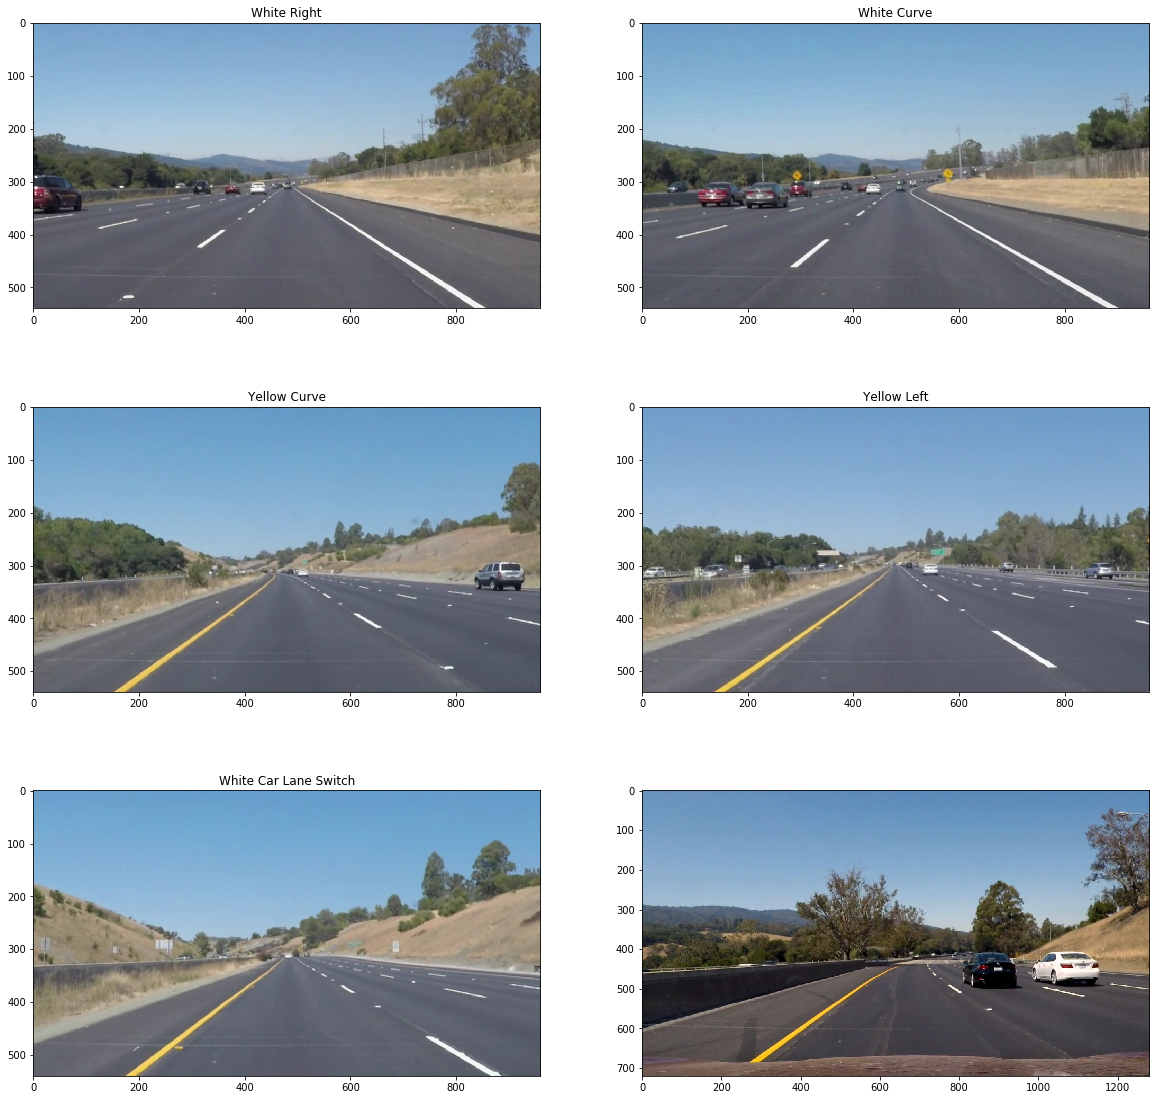

In [74]:
import os

image_list = os.listdir("test_images/")
count = len(image_list)

plt.figure(figsize=(20,20))
plt.subplot(321),plt.imshow(image1),plt.title('White Right')
plt.subplot(322),plt.imshow(image2),plt.title('White Curve')
plt.subplot(323),plt.imshow(image3),plt.title('Yellow Curve')
plt.subplot(324),plt.imshow(image4),plt.title('Yellow Left')
plt.subplot(325),plt.imshow(image5),plt.title('White Car Lane Switch')
plt.subplot(326),plt.imshow(image7)

plt.show()

# Step by Step workflow (testing)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


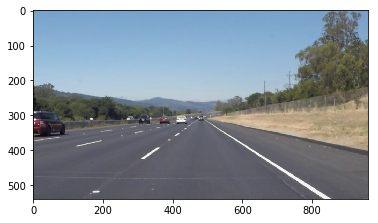

In [3]:
#default image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  

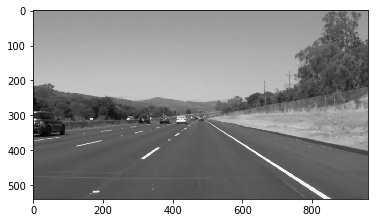

In [4]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(grayscale(image), cmap='gray')

## Mask only yellow and white

In [ ]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image)

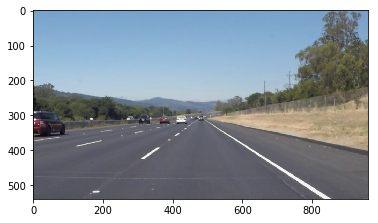

In [6]:
plt.imshow(image)

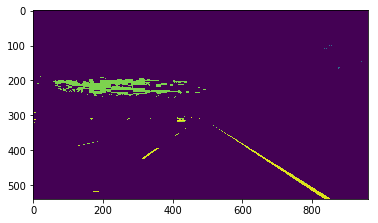

In [7]:
img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Set the definition for "yellow"
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])

# Now change the image to mask yellow
mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
mask_white = cv2.inRange(gray_image, 205, 255)

# Now combine yellow and white masks
mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
mask_yw_image = cv2.bitwise_and(gray_image, mask_yw)

plt.imshow(mask_yw_image)

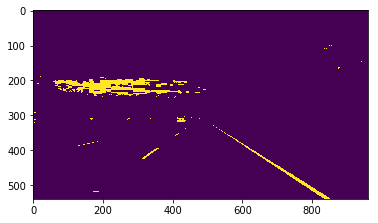

In [8]:
plt.imshow(mask_yw)

## Gaussian Blur

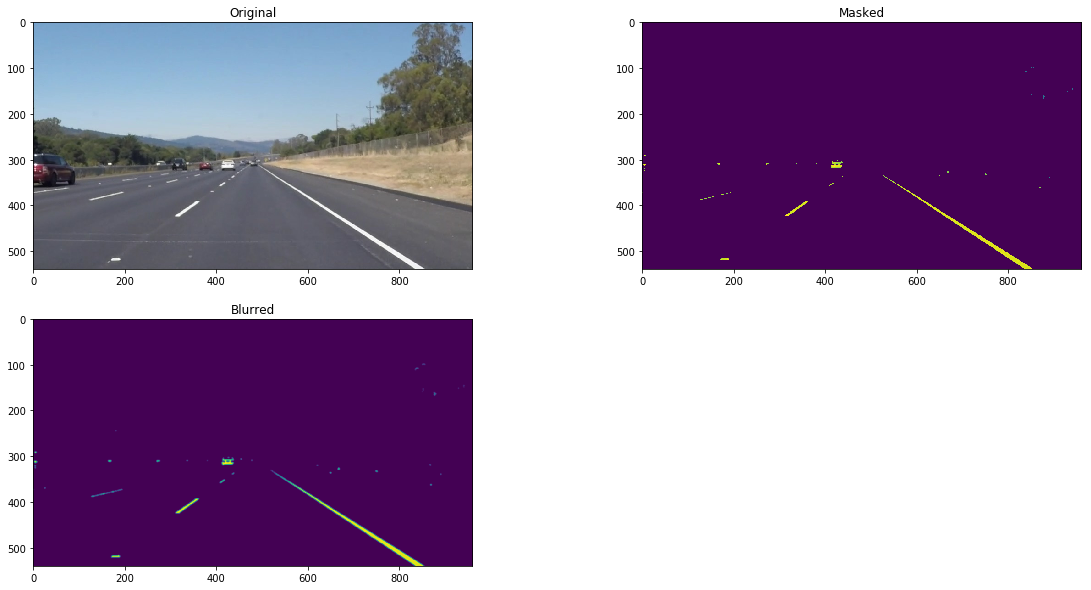

In [150]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

image = mpimg.imread('test_images/solidWhiteRight.jpg')
img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Set the definition for "yellow"
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])

# Now change the image to mask yellow
mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
mask_white = cv2.inRange(gray_image, 205, 255)

# Now combine yellow and white masks
mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
mask_yw_image = cv2.bitwise_and(gray_image, mask_yw)
orig_image =  cv2.imread('test_images/solidWhiteRight.jpg')
gauss_gray = cv2.GaussianBlur(mask_yw_image,(5,5), 0)

plt.figure(figsize=(20,10))
plt.subplot(221),plt.imshow(image),plt.title('Original')

plt.subplot(222),plt.imshow(mask_yw_image),plt.title('Masked')

plt.subplot(223),plt.imshow(gauss_gray),plt.title('Blurred')


plt.show()

## Canny Edge Detection

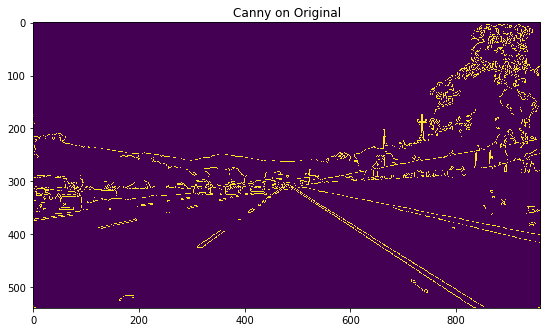

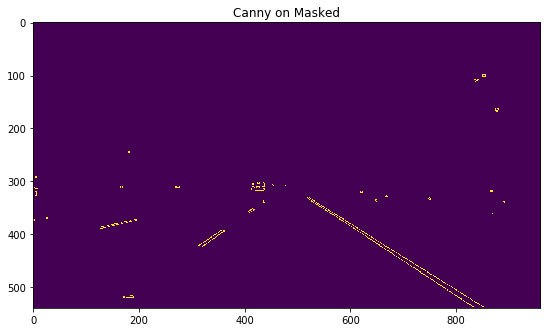

In [10]:
gauss_gray = cv2.GaussianBlur(mask_yw_image,(5,5), 0)

low_threshold = 50
high_threshold = 150
canny_edges1 = canny(image,low_threshold,high_threshold)
canny_edges2 = canny(gauss_gray,low_threshold,high_threshold)


plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(canny_edges1),plt.title('Canny on Original')

plt.figure(figsize=(20,10))
plt.subplot(122),plt.imshow(canny_edges2),plt.title('Canny on Masked')


plt.show()

## Region of Interest

CHECKPOINT 1
CHECKPOINT 1


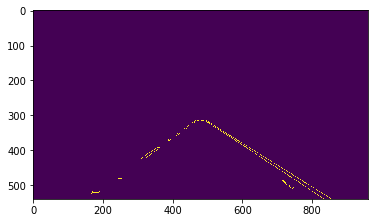

In [23]:
vertices = [np.array([[130,540],[465,315],[500,315],[860,540]], dtype=np.int32)]


ROI_masked = region_of_interest(canny_edges1, vertices)

plt.imshow(ROI_masked)

## Testing right border on original image

In [13]:
#import numpy as np
#import cv2


#image = mpimg.imread('test_images/solidWhiteRight.jpg')


# Draw a polygon
#pts = np.array([[130,540],[465,315],[500,315],[860,540]], np.int32)
#cv2.polylines(image,[pts],True,(0,255,255))

#Display the image
#cv2.imshow("img",image)

#cv2.waitKey(0)
#cv2.destroyAllWindows()

## Now need to use this information to draw lines.... Hough Transform??

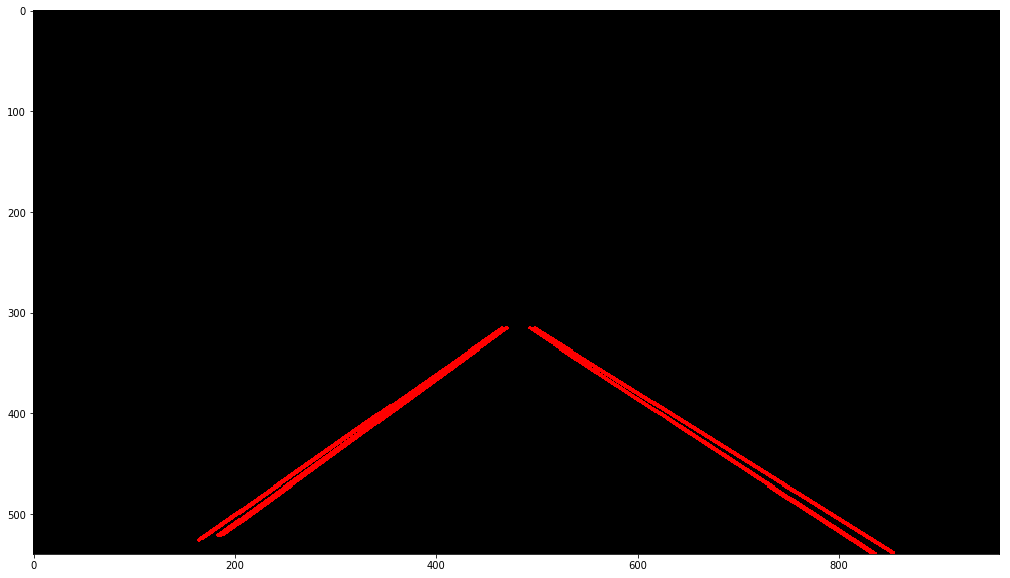

In [109]:
hough_image1 = hough_lines(ROI_masked, 1, np.pi/180, 10, 100, 200
                          )

#rho and theta are the distance and angular resolution of the grid in Hough space
#same values as quiz
rho = 1
theta = np.pi/180
#threshold is minimum number of intersections in a grid for candidate line to go to output
threshold = 10
min_line_len = 100
max_line_gap = 200

plt.figure(figsize=(20,10))
hough_image2 = hough_lines(ROI_masked, rho, theta, threshold, min_line_len, max_line_gap)

plt.imshow(hough_image2)

## Weighted Image

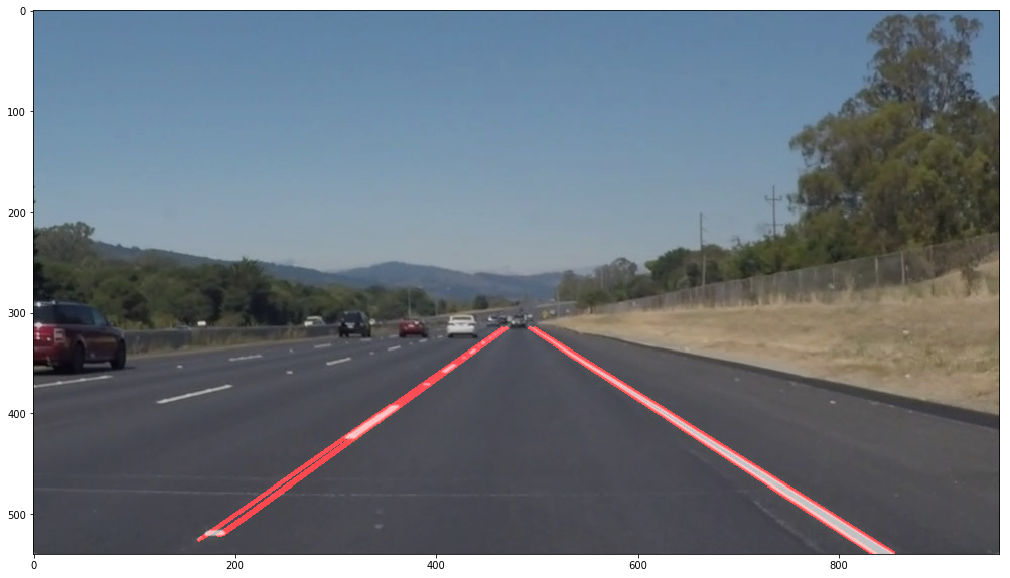

In [74]:
weighted_image = weighted_img(hough_image2, image, α=.8, β=1., λ=0.)

plt.figure(figsize=(20,10))
plt.imshow(weighted_image)



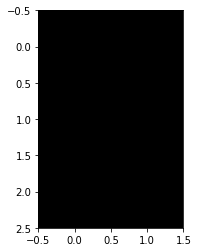

In [194]:
black = np.zeros((3, 2, 3), dtype=np.uint8)
plt.imshow(black)

In [192]:
print (black.shape)

(2, 2, 3)


In [195]:
print(black)

[[[0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]]]
